## 4.0. Multiphase Flow Meter Virtualization
* Objective is to determine if a virtual multiphase flow meter can be constructed using machine learning rather than physical modeling.
### Regression problem

### Load Python Libraries

In [1]:
# Data storage, exploration
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data imputing
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# ML Model libraries

# The following three lines allow multiple and non-truncated outputs 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', None)

# Import Data & Preliminary Data Exploration
1. How many data records? 
2. How many variables / features or columns in each data record?
3. Peek at the first five records and the last five records

In [2]:
# Import Data
mpfm_file = '/content/drive/MyDrive/ALCE-22/MPFM.XLSX'
mpfm = pd.read_excel(mpfm_file)

In [3]:
mpfm.info()
mpfm.head()
mpfm.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67418 entries, 0 to 67417
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   time                  67418 non-null  datetime64[ns]
 1   ref_oil_rate          67418 non-null  float64       
 2   ref_water_rate        67418 non-null  float64       
 3   ref_gas_rate          67418 non-null  float64       
 4   well                  67418 non-null  int64         
 5   reservoir             67418 non-null  int64         
 6   dht                   67418 non-null  float64       
 7   dhp                   67418 non-null  float64       
 8   wht                   67418 non-null  float64       
 9   whp                   67418 non-null  float64       
 10  chokeprod             67418 non-null  float64       
 11  chokegaslift          66997 non-null  float64       
 12  chokepressdownstream  67418 non-null  float64       
 13  gasliftrate     

,time,ref_oil_rate,ref_water_rate,ref_gas_rate,well,reservoir,dht,dhp,wht,whp,chokeprod,chokegaslift,chokepressdownstream,gasliftrate,gasliftpressure,flowlinepressure
0,2018-01-07 15:00:00,9.57898,43.836300,3663.219971,7,1,96.898201,124.392998,79.918999,15.673000,16.976601,NaN,15.343800,2974.610107,132.201996,8.03727
1,2018-01-07 15:01:00,9.19413,44.137501,5480.009766,7,1,96.898697,124.433998,80.146400,16.755699,16.960501,NaN,16.070999,2956.870117,132.231003,7.78466
2,2018-01-07 15:02:00,9.36465,43.702499,5549.779785,7,1,96.899200,124.466003,80.221802,17.285299,16.964100,NaN,16.870199,2923.840088,132.360992,7.93908
3,2018-01-07 15:03:00,9.37921,43.661999,4991.160156,7,1,96.899300,124.449997,80.028603,17.504400,16.948900,NaN,17.115200,2872.360107,132.363007,7.96528
4,2018-01-07 15:04:00,8.13360,43.144402,5281.500000,7,1,96.900101,124.467003,80.101402,16.039400,16.955900,NaN,15.599400,2857.760010,132.238998,8.10715


,time,ref_oil_rate,ref_water_rate,ref_gas_rate,well,reservoir,dht,dhp,wht,whp,chokeprod,chokegaslift,chokepressdownstream,gasliftrate,gasliftpressure,flowlinepressure
67413,2019-08-27 10:26:00,0.073933,138.024994,3395.530029,28,1,97.007202,192.231003,89.576797,9.64965,91.559402,35.001701,9.19412,2195.239990,189.755997,8.36684
67414,2019-08-27 10:27:00,0.053863,140.677002,2895.649902,28,1,97.007202,192.205002,89.645401,9.56417,91.595398,35.001701,9.03423,2173.629883,189.714996,8.16373
67415,2019-08-27 10:28:00,0.074303,140.535995,2767.030029,28,1,97.007202,192.199005,89.516403,9.47887,91.588699,35.001701,9.15015,2064.340088,189.673996,8.12229
67416,2019-08-27 10:29:00,0.091738,139.298996,2722.979980,28,1,97.007202,192.194000,89.612198,9.40966,91.553902,35.001701,9.07940,2063.320068,189.677994,8.24969
67417,2019-08-27 10:30:00,0.007333,139.860001,2827.409912,28,1,97.007202,192.207001,89.637604,9.62142,91.588997,35.001701,9.23502,2199.149902,189.720993,8.36687


## Examine Data / think / discuss
1. Do we need time column?
2. Order of columns is not intuitive
   1. Outputs or targets __ref_oil_rate, ref_water_rate, ref_gas_rate__ are in the beginning 
       1. multioutput regression problem
       2. Do we need all three? Won't just one do? Which one????
   2. Chokes and gas-lift rate impact production.
   3. Pressures can be organized together in the order from bottomhole to the surface.
   4. Temperature columns may be at the end just before targets.
3. **Note**: Well and Reservoir are provided as numeric columns.Generally, they are categorical variables (having specific and distinct values rather than continuous real-values that a numeric variable would get). The numbers are ordinal values probably.

In [4]:
mpfm.drop(columns=['time'], inplace=True)
reorder = ['well', 'reservoir','chokeprod', 'chokegaslift', 'dhp', 'whp', 'chokepressdownstream', 'flowlinepressure', 'gasliftpressure', 'dht', 'wht', 'gasliftrate', 'ref_oil_rate', 'ref_water_rate', 'ref_gas_rate']
mpfm = mpfm[reorder]

mpfm['ref_liq_rate'] = mpfm.ref_oil_rate + mpfm.ref_water_rate

# # Convert Well and Reservoir to categorical variables
categoricals = ['well', 'reservoir']
mpfm[categoricals] = mpfm[categoricals].astype('category')
mpfm_num = mpfm.drop(columns=categoricals);

mpfm_num.head()
mpfm_num.describe()

,chokeprod,chokegaslift,dhp,whp,chokepressdownstream,flowlinepressure,gasliftpressure,dht,wht,gasliftrate,ref_oil_rate,ref_water_rate,ref_gas_rate,ref_liq_rate
0,16.976601,NaN,124.392998,15.673000,15.343800,8.03727,132.201996,96.898201,79.918999,2974.610107,9.57898,43.836300,3663.219971,53.415280
1,16.960501,NaN,124.433998,16.755699,16.070999,7.78466,132.231003,96.898697,80.146400,2956.870117,9.19413,44.137501,5480.009766,53.331631
2,16.964100,NaN,124.466003,17.285299,16.870199,7.93908,132.360992,96.899200,80.221802,2923.840088,9.36465,43.702499,5549.779785,53.067149
3,16.948900,NaN,124.449997,17.504400,17.115200,7.96528,132.363007,96.899300,80.028603,2872.360107,9.37921,43.661999,4991.160156,53.041209
4,16.955900,NaN,124.467003,16.039400,15.599400,8.10715,132.238998,96.900101,80.101402,2857.760010,8.13360,43.144402,5281.500000,51.278002


,chokeprod,chokegaslift,dhp,whp,chokepressdownstream,flowlinepressure,gasliftpressure,dht,wht,gasliftrate,ref_oil_rate,ref_water_rate,ref_gas_rate,ref_liq_rate
count,67418.000000,66997.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000,67418.000000
mean,80.070411,34.214641,106.773066,19.620908,18.773546,8.200944,115.236679,69.164995,80.216924,3512.520331,4.158301,68.297679,6253.530197,72.455979
std,28.136405,26.409122,68.960622,16.700770,16.454347,0.583610,80.999421,43.091461,17.740387,1745.298974,5.274502,43.475246,2850.049493,44.330006
min,-0.473121,0.000000,-772.953003,6.849540,0.071163,0.074144,0.000000,0.000000,0.000000,0.000000,0.001618,0.129395,2.970620,0.156511
25%,54.465801,16.000000,0.000000,9.597290,9.056195,7.966315,0.000000,0.000000,78.102649,2647.984985,0.545690,40.463550,4342.517700,46.386625
50%,98.875000,30.000000,135.931000,11.114450,10.253650,8.181705,155.518005,96.489304,80.775902,3690.964966,1.614420,56.682900,5939.484863,60.666606
75%,99.370102,40.000000,166.985992,27.928875,23.459900,8.436212,180.358994,97.112801,86.039051,4762.742554,7.211280,82.912975,7473.557617,85.298083
max,112.432999,100.000000,197.408005,82.361801,74.034302,10.274200,209.074005,231.356003,133.154007,8650.259766,68.714203,228.595993,23028.000000,230.117080


## Statistics on each column / feature / variable
1. What are NaNs in the first five records for <b>chokegaslift</b>? There could be more in other records for this variable... and for other(s).
2. Review how many measurements for each variable in the <b>count</b> row. Why chokegaslift has less measurements? NaNs? How many? 
3. Review Mean, min, std dev and percentile values for each variable. 
    1. Could min-values be negative for <b>chokeprod, dhp</b>? 
    2. How about min-values being zero for certain variables?
    3. What are the median values?
4. What does it mean when 25% percentile-value is 0.0 for <b>dhp, gasliftpressure, dht</b> variables?

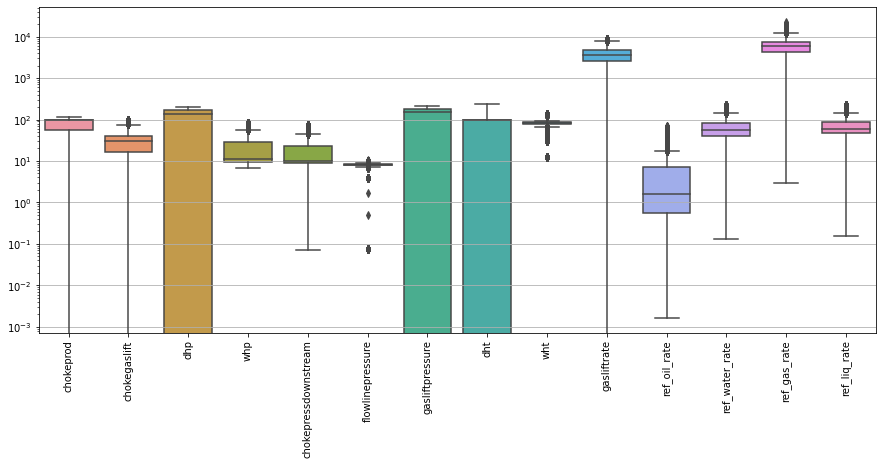

In [5]:
# plot statistics
plt.figure(figsize=(15,6));
plt.yscale("log");
plt.grid('y');
plt.xticks(rotation='vertical')
sns.boxplot(data=mpfm_num);

#### Boxplot Visualization
In the visualization above, why some boxes are very tall (long color bars).
1. Which variable has the smallest distribution?
2. Which variable is widely distributed?
3. What does it mean when one whisker is longer than the other?

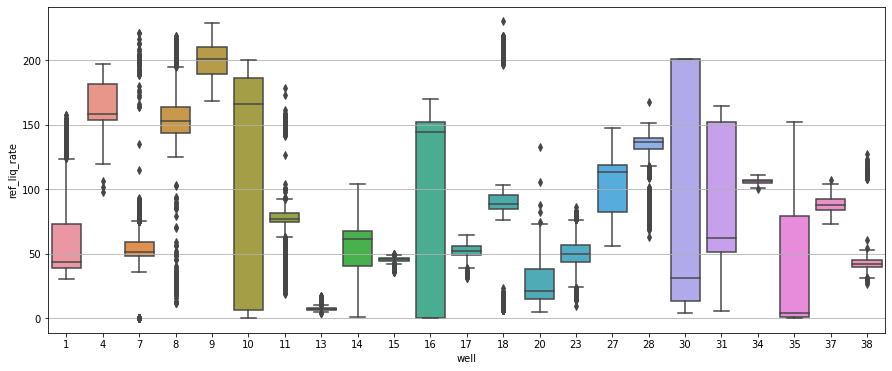

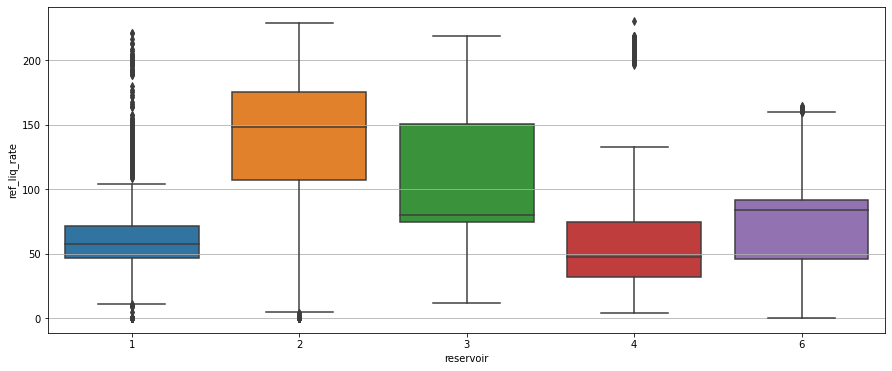

In [6]:
plt.figure(figsize=(15,6));
plt.grid('y');
sns.boxplot(data=mpfm, x="well", y="ref_liq_rate");
plt.figure(figsize=(15,6));
plt.grid('y');
sns.boxplot(data=mpfm, x="reservoir", y="ref_liq_rate");

### Histograms
Help visualize how measurements are distributed.
Wouldn't we like them to be normally distributed?!?

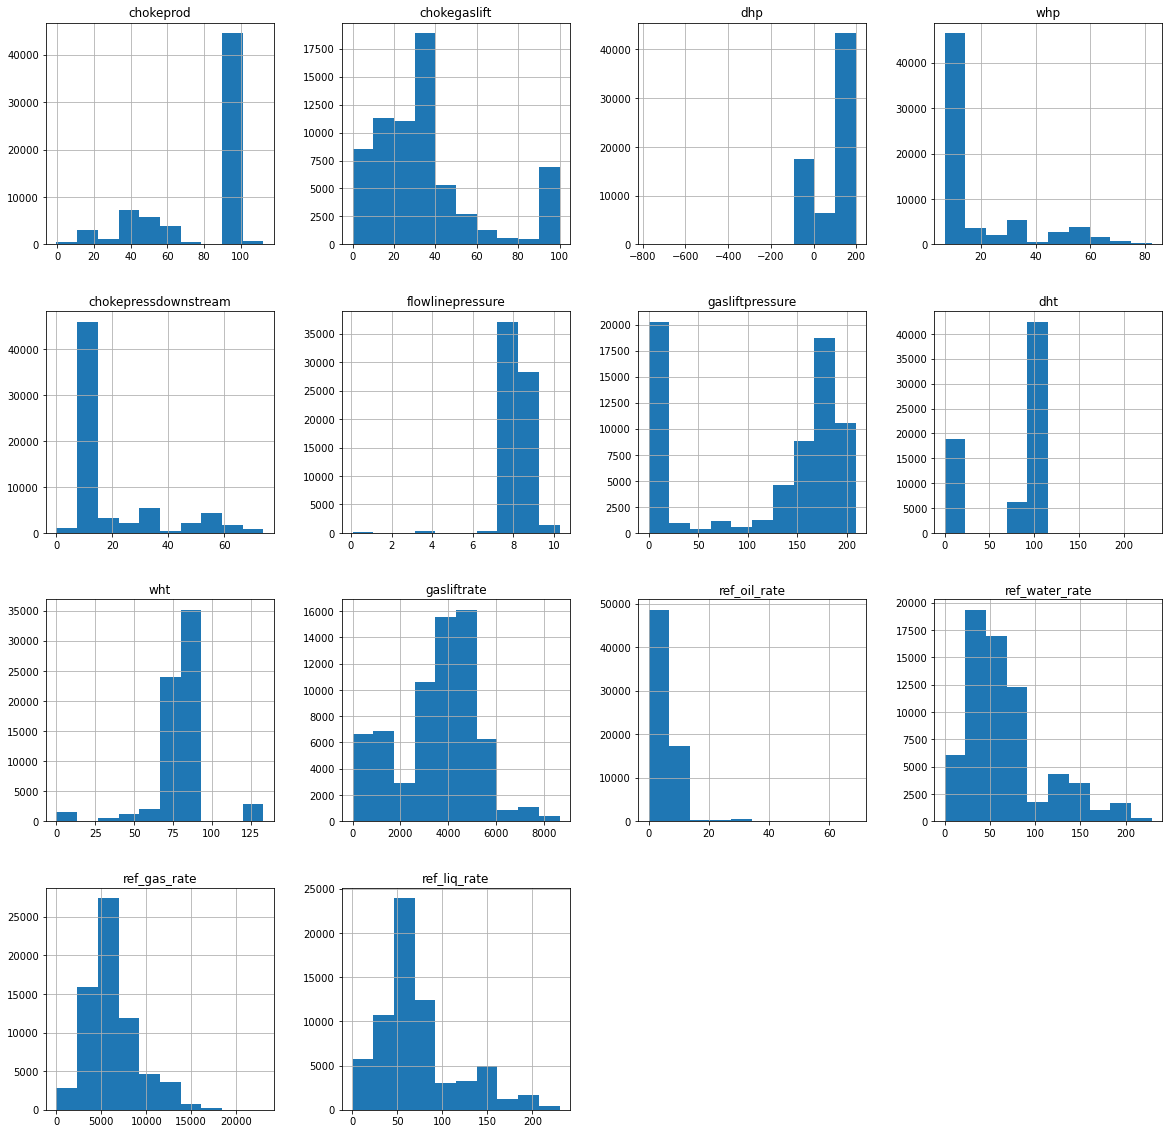

In [7]:
mpfm.hist(figsize=(20, 20));

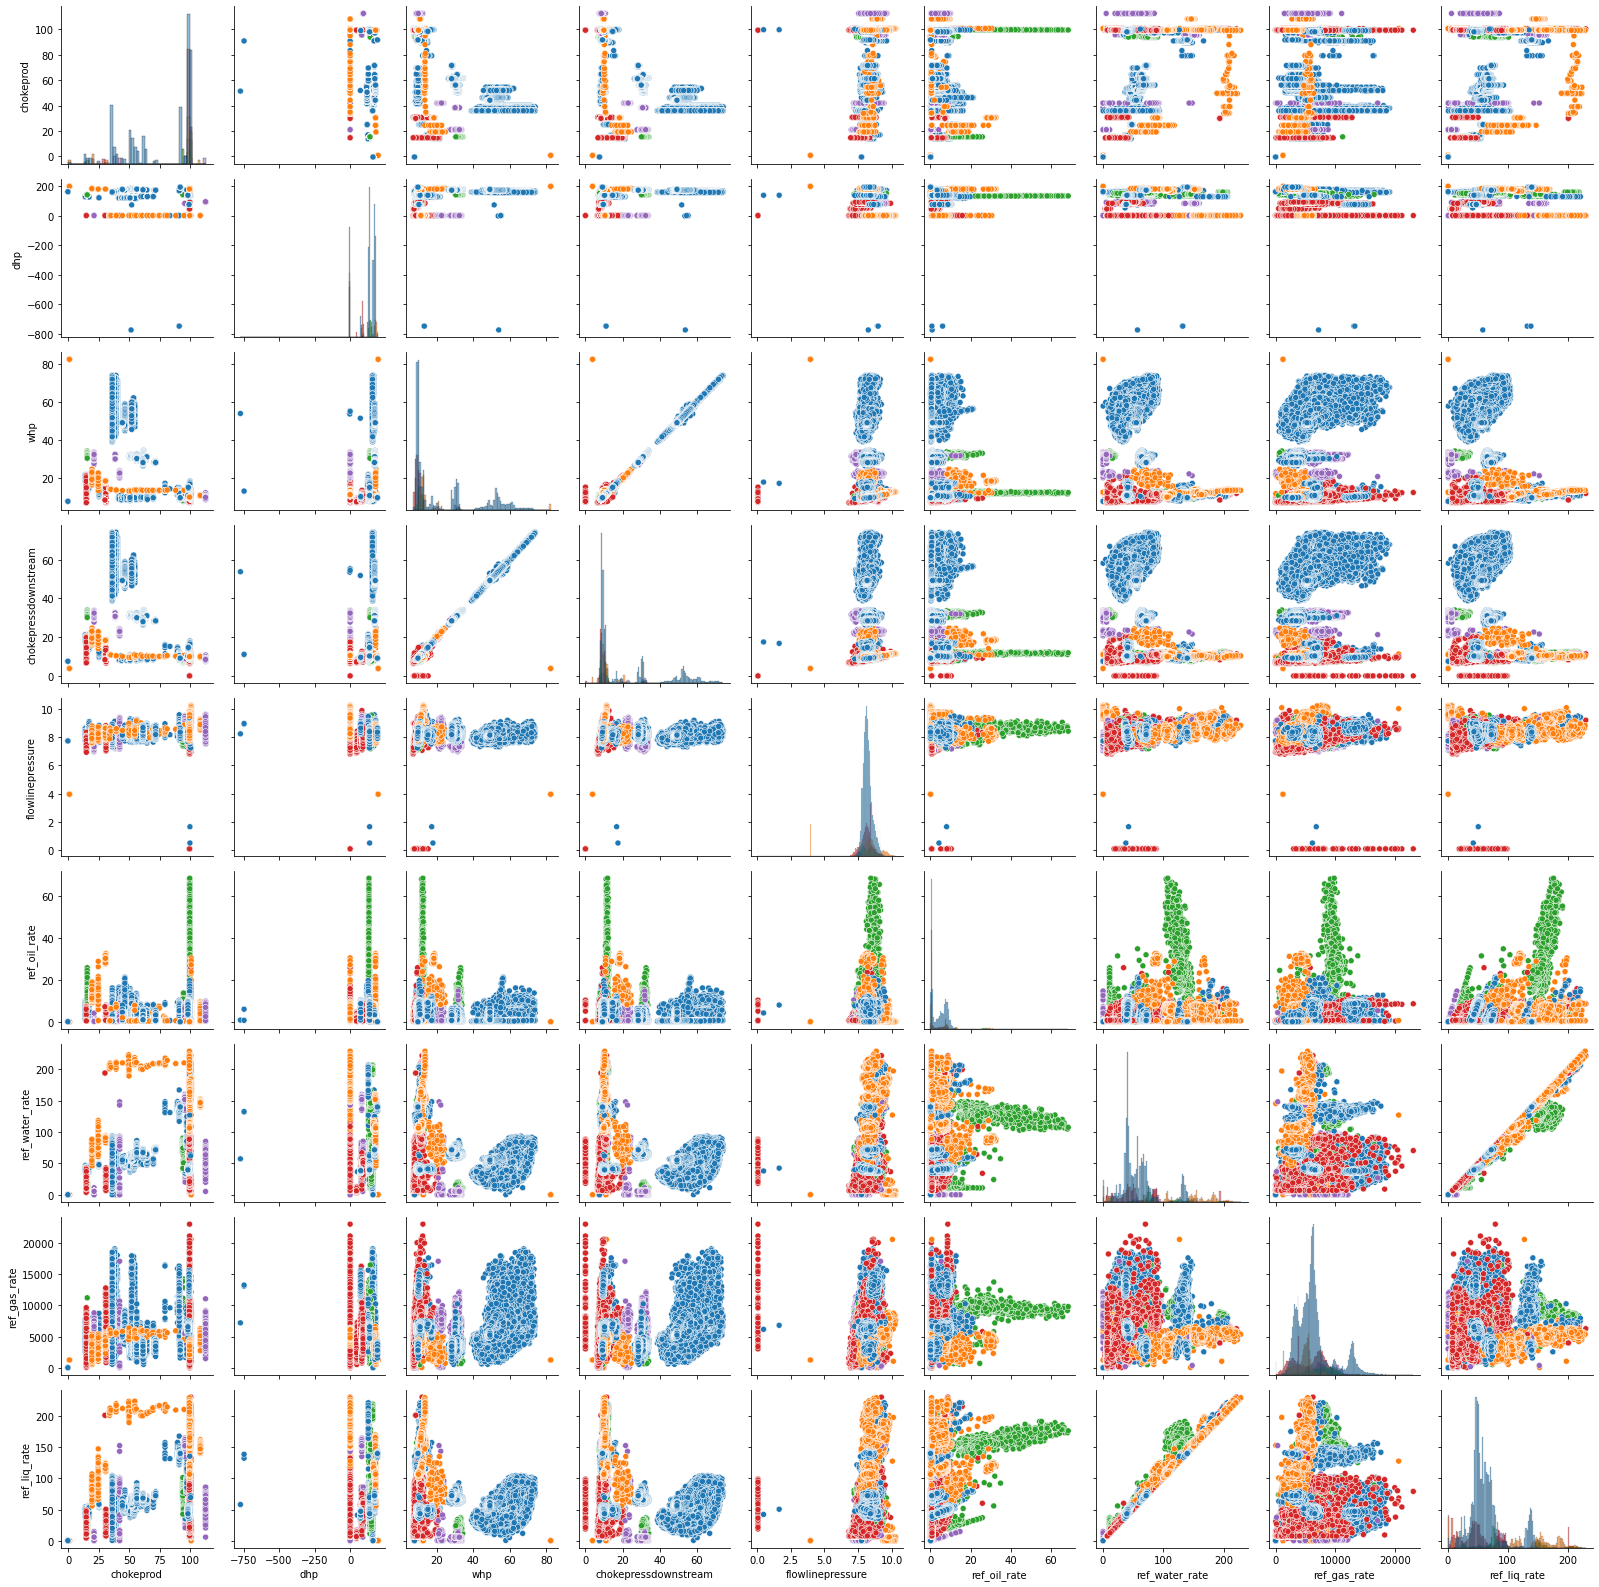

In [8]:
plot_vars=['chokeprod', 'dhp', 'whp', 'chokepressdownstream', 'flowlinepressure', 
           'ref_oil_rate', 'ref_water_rate','ref_gas_rate',
           'ref_liq_rate']

# Define a function to plot histogram and scatterplot for the specified variables/columns of provided dataframe 
def plotPairgrid(df, plot_vars=['chokeprod', 'dhp', 'whp', 'chokepressdownstream', 'flowlinepressure',
                                'ref_oil_rate', 'ref_water_rate','ref_gas_rate']):
    g = sns.PairGrid(data=df, vars=plot_vars, hue='reservoir', diag_sharey=False);
#    g.map_upper(sns.scatterplot, s=15);
#    g.map_lower(sns.kdeplot);
    #g.map_diag(sns.kdeplot, lw=2);
    g.map_diag(sns.histplot);
    g.map_offdiag(sns.scatterplot);


plotPairgrid(mpfm, plot_vars);

### Correlations between Variables
Let's find out if two variables are correlated by calculating correlation coefficients between two variables. 
1. Positive value (positive correlation) means one increases with another in the dataset; and 
2. Negative value (negative correlation) means one decreases while another increases and vice versa. 
3. Magnitude of the correlation coefficient indicates strength of the correlation.

#### Why do we want to perform this exercise?

There are multiple ways to perform this task. We will calculate Pearson and Spearman coefficeints.
#### Pearson Correlation Coefficient
Pearson correlation assumes that the data we are comparing is normally distributed. When that assumption is not true, the correlation value is reflecting the true association.

#### Spearman Rank Correlation
Spearman correlation does not assume that data is from a specific distribution, so it is a non-parametric correlation measure. Spearman correlation is also known as Spearman’s rank correlation as it computes correlation coefficient on rank values of the data.

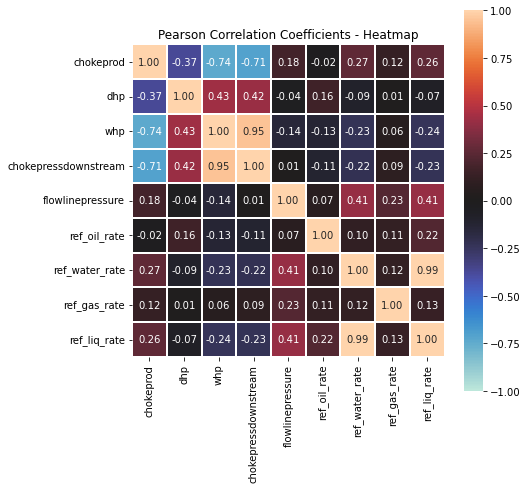

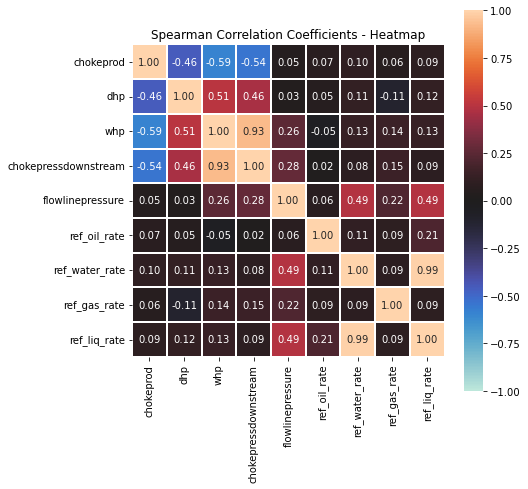

In [9]:
def plot_corrcoeff(method):
    fig, ax = plt.subplots(figsize=(7, 7))

    dfCorr = mpfm[plot_vars].corr(method=method)
    g1 = sns.heatmap(dfCorr, center=0.0, linewidths=0.3, square=True, annot=True, vmin=-1, vmax=1., fmt='1.2f')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=90);
    g1.set_title(method.capitalize() + ' Correlation Coefficients - Heatmap')
    plt.show()

# Pearson Correlation Coefficient
plot_corrcoeff(method='pearson')

# Spearman Rank Correlation
plot_corrcoeff(method='spearman')

# Data Exploration
### Missing Data at Macro Level
1. In the box plots above, <b>chokeprod, chokegaslift, dhp, gasliftpressure, dht, gasliftrate</b> have almost zero or negative values
2. There may be some null (NaN) measurements for some of these data columns.

In [10]:
# Q1. How many nulls are there?
mpfm.isnull().sum()

# Q2. How many values are zero or -ve
(mpfm[plot_vars] <= 0.0).sum()

well                      0
reservoir                 0
chokeprod                 0
chokegaslift            421
dhp                       0
whp                       0
chokepressdownstream      0
flowlinepressure          0
gasliftpressure           0
dht                       0
wht                       0
gasliftrate               0
ref_oil_rate              0
ref_water_rate            0
ref_gas_rate              0
ref_liq_rate              0
dtype: int64

chokeprod                 181
dhp                     17589
whp                         0
chokepressdownstream        0
flowlinepressure            0
ref_oil_rate                0
ref_water_rate              0
ref_gas_rate                0
ref_liq_rate                0
dtype: int64

## Data Exploration - Slightly Deeper Dive
1. <b>Missing Data</b>
    1. Which wells have null values for the chokegaslift variable?
    2. No gaslift pressure but +ve gaslift rate
2. <b>Illogical data</b>
    1. whp <= flp and Qliquid > 0.0
    2. dhp > 0.0 but <= whp
3. <b>Overall number of Impaired records</b>: Having one or more issues with data

<b>Any others, you'd like to check?</b> 

In [11]:
# Null records for the chokegaslift variable
mpfm[mpfm.chokegaslift.isnull()].well.unique()

# Qgl > 0.0 but Pgaslift is 0.0 or -ve?
((mpfm.gasliftpressure <= 0.0) & (mpfm.gasliftrate >= 0.0)).sum()

# Records with whp <= flowlinepressure and liquid flowrate > 0.0  <-- 904
((mpfm.whp <= mpfm.flowlinepressure) &  ((mpfm.ref_oil_rate + mpfm.ref_water_rate) > 0.0)).sum()

# 904 records with WHP <= FLP / dhp <= 0 <- 17589 / ProdChoke -ve 181
# 17781 records  
((mpfm.dhp <= 0.0) | (mpfm.chokeprod <= 0.0) |
 ((mpfm.whp <= mpfm.flowlinepressure) & ((mpfm.ref_oil_rate + mpfm.ref_water_rate) > 0.0)) |
 (mpfm.dht <= 0.0) | (mpfm.wht <= 0.0) | (mpfm.gasliftrate <= 0.0) | (mpfm.gasliftpressure <= 0.0)
 ).sum()

[7]
Categories (23, int64): [1, 4, 7, 8, ..., 34, 35, 37, 38]

20314

904

38200

## Data Cleaning
1. Convert negatives or zeros to Nan
2. Production choke has some weird values around 0 (< 1.0). Set them to NaN
3. Recheck histograms

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


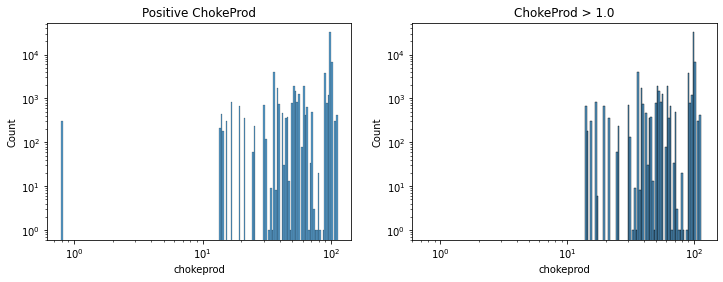

In [12]:
mpfm_positives = mpfm_num.where(mpfm_num > 0.0, other=np.nan)

mpfm_positives['chokeprod'] = np.where(mpfm_positives['chokeprod'] < 1.0, np.nan, mpfm_positives['chokeprod'])

plt.figure(figsize=(12, 4));
plt.subplot(121, title='Positive ChokeProd');
sns.histplot(x=mpfm.chokeprod, log_scale=(True, True));

plt.subplot(122, title='ChokeProd > 1.0');
aa = sns.histplot(x=mpfm_positives.chokeprod, log_scale=(True, True));
aa.set_xlim(0.6, 150);

In [13]:
# Separate targets from inputs
targets = ['ref_oil_rate', 'ref_water_rate', 'ref_gas_rate']#, 'ref_liq_rate']

y = mpfm_positives[targets].to_numpy()
X = mpfm_positives.drop(columns=targets).to_numpy()

In [14]:
# Do we have nulls in targets and inputs?
np.isnan(y).any(), np.isnan(X).any()

(False, True)

### Impute missing values

In [15]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Replace missing values by nearest neighbor
imputer = KNNImputer(n_neighbors = 2)
X = imputer.fit_transform(X)

In [16]:
# Normalize inputs
from sklearn.preprocessing import Normalizer
Normalizer().fit_transform(X)

array([[0.00569114, 0.00636818, 0.04170078, ..., 0.03248359, 0.02679158,
        0.99719089],
       [0.00571962, 0.00640613, 0.04196312, ..., 0.03267734, 0.02702793,
        0.99715111],
       [0.00578506, 0.00647804, 0.04244509, ..., 0.03304433, 0.02735704,
        0.99708078],
       ...,
       [0.04385452, 0.01675952, 0.09202876, ..., 0.046449  , 0.04286226,
        0.98844766],
       [0.04385898, 0.0167676 , 0.09207071, ..., 0.04647139, 0.0429288 ,
        0.98843531],
       [0.04122242, 0.01575358, 0.08650863, ..., 0.04366105, 0.04034414,
        0.98979455]])

### Sub-divide datatest into training and testing: 70 - 30% split

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, random_state=1002)

### Method Evaluation using Multiple Metrics

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

def calc_predMetrics(y_true, y_pred, method):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'method':method, 'rmse':rmse, 'MAPE':mape, 'R2':r2}

pred_perf_metric = []

### Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(max_depth=100, splitter='best', 
                           criterion='squared_error', random_state=1002)
y_pred_dt = dt.fit(X_train, y_train).predict(X_test)

pred_perf_metric.append(calc_predMetrics(y_test, y_pred_dt, method="Decision Tree"))

### Support Vector machine Regressor

In [ ]:
# Takes very long so commented out for class exercise
from sklearn.multioutput import MultiOutputRegressor

from sklearn.svm import SVR
svr = SVR(kernel="rbf")
y_pred_svr = MultiOutputRegressor(svr).fit(X_train, y_train).predict(X_test)
pred_perf_metric.append(
    calc_predMetrics(y_test, y_pred_svr, method="Support Vector Regression"))

### Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=1000, max_depth=1000, 
                           criterion='squared_error', random_state=0)
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)
pred_perf_metric.append(calc_predMetrics(y_test, y_pred_rf, method="Random Forest" ))

### Extra Trees Regressor

In [21]:
from sklearn.ensemble import ExtraTreesRegressor
et = ExtraTreesRegressor(n_estimators=1000, max_depth=1000, 
                           criterion='squared_error', random_state=0)
y_pred_et = et.fit(X_train, y_train).predict(X_test)
pred_perf_metric.append(calc_predMetrics(y_test, y_pred_et, method="Extra Trees"))

### XGBoost

In [ ]:
import xgboost as xgb
xgbm = xgb.XGBRegressor()
y_pred_xgb = MultiOutputRegressor(xgbm).fit(X_train, y_train).predict(X_test)
pred_perf_metric.append(calc_predMetrics(y_test, y_pred_xgb, method="XGBoost"))

### ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

nn = Sequential()
nn.add(Dense(200, input_dim=X.shape[1], activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(50, activation='selu', kernel_initializer='he_uniform'))
nn.add(Dense(4, activation='selu'))

# compile model
nn.compile(loss='mean_squared_error', optimizer=RMSprop(learning_rate=0.01))
# fit model
nn.fit(X_train, y_train, epochs=100, verbose=0)
# evaluate the model
y_pred_nn = nn.predict(X_test)
pred_perf_metric.append(calc_predMetrics(y_test, y_pred_nn, method="ANN"))

In [ ]:
X.shape

In [ ]:
# Plot Relative Performances
plotDf = pd.DataFrame(pred_perf_metric)
fig, axs = plt.subplots(1, 3, figsize=(12, 6), sharey=True)
rect1 = axs[0].barh(plotDf.method, plotDf.rmse)
axs[0].set_title('RMSE, bbls/day')
axs[0].bar_label(rect1, padding=1, fmt='%.1f')
axs[0].set_xlim(0., 4000.)

rect2 = axs[1].barh(plotDf.method, plotDf.MAPE)
axs[1].set_title('MAPE, %')
axs[1].bar_label(rect2, padding=1, fmt='%.3f')
axs[1].set_xlim(0., 0.6)

rect3 = axs[2].barh(plotDf.method, plotDf.R2)
axs[2].set_title('R2 Coefficient')
axs[2].bar_label(rect3, padding=0, fmt='%.3f')
axs[2].set_xlim(0., 1.2)

fig.suptitle('ML Methods Comparison')